<a href="https://colab.research.google.com/github/RossanadC/Machine-Learning/blob/main/Lab06_audio_keyword_spotting_assignment_withDataAgumentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keyword spotting

Keyword spotting (KWS) is a typical problem defined in the context of speech processing. A special case of KWS is the case of wake word detection that is commonly used by personal digital assistants as Alexa and Siri to “wake up” when their command is spoken. This is not the case of speech recognition, that needs much more complex systems and structures, but this approach can be used to identify a set of commands to operate on a personal device.

The objective of this lab is to experiment with a workflow for training a simple network that can learn how to detect know commands in one second of audio, e.g., 'up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no'.

Some of the steps described in this document are implemented in the notebook “ml4vmm24_lab05_audio.ipynb” provided with the lab material (the current file). Activities to be performed by the student are identified with the keyword **“Task”**.

**Note.** The notebook modifies the Pytorch tutorial on [Speech Command Classification with Torchaudio](https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html) by using both Waveform and Mel Spectrogram as input to the Network Model and, optionally, using [*audio feature augmentation*](https://pytorch.org/audio/main/tutorials/audio_feature_augmentation_tutorial.html).

## Preliminaries

Before starting, review or have ready the following material:

* Lesson "14. Machine and Deep Learning for Audio" slides and recording

* Pytorch tutorial on Speech Command Classification
https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html

* Pytorch tutorial on Audio Feature Extractions to compute and represent the Mel Spectrogram
https://pytorch.org/audio/main/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py

* Pytorch tutorial on Audio Data Augmentation to extend the set of samples fo the training
https://pytorch.org/audio/stable/tutorials/audio_data_augmentation_tutorial.html



## Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import librosa
import torchvision
import numpy as np

import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd

from tqdm import tqdm
%matplotlib inline

from torchsummary import summary


In [2]:
!pip install torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.0 MB/s eta 0:00:00


### Get Computational Device




In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Importing the Dataset

We use torchaudio to download and represent the dataset. Here we use
[SpeechCommands](https://arxiv.org/abs/1804.03209), which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is being accessed, and torchaudio takes care of converting the audio files to tensors. If one wants to load an audio file directly instead, `torchaudio.load()` can be used. It returns a tuple containing the newly created tensor along with the sampling frequency of the audio file (16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into standard training, validation, testing subsets.

**Note.** In order to speed up the learning process, we restrict the number of different commands to a subset of the original thirtyfive commands: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero'] (see the `commands` set).




In [4]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None, labels = {}):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        def filter_labels(walker):
            return [ w for w in walker if os.path.split(os.path.split(w)[0])[1] in labels ]

        # labels = { 'yes', 'no' }

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes ]

        # for i, file_path in enumerate(self._walker):
        #     print(subset, get_label(file_path), file_path)
        if len(labels):
          self._walker = filter_labels(self._walker)


# Limit to a subset of all the 35 commands
commands = {'up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no'}
print("Selected command subset from the dataset: ", commands);

# Create training and testing split of the data.
train_set = SubsetSC("training", commands)
test_set = SubsetSC("testing", commands)
valid_set = SubsetSC("validation", commands)



Selected command subset from the dataset:  {'yes', 'left', 'down', 'no', 'up', 'right', 'go', 'stop'}


100%|██████████| 2.26G/2.26G [00:29<00:00, 83.2MB/s]


## Esplorazione dei dati

Un punto dati nel dataset SPEECHCOMMANDS è una tupla composta da: [una forma d'onda
(il segnale audio), la frequenza di campionamento, l'enunciato (etichetta), l'ID
del parlante, il numero dell'enunciato.]

**Attività: Grafico della forma d'onda.** Seleziona un campione dal dataset (ad esempio, idx=1), traccia la forma d'onda e stampane la forma. Ascolta lo stesso campione con "ipd.Audio(<forma d'onda>, <frequenza>)"

```
Lunghezza del set di addestramento: 24713
Lunghezza del set di test: 3276
Metadati del campione. Etichetta: down, Parlante: 004ae714, N. enunciato. 0
Forma della forma d'onda: torch.Size([1, 16000])
Numero di canali: 1
Numero di campioni: 16000
Frequenza di campionamento della forma d'onda: 16000 Hz
```

![picture](https://gist.githubusercontent.com/servetti-polito/b976ba016411f0c3905bf89e18a28899/raw/0a3cace1bcae8518e974a270c3b6fbb8acb01a7c/utterance-waveform.png)




Train set length: 24713
Test set length: 3276
Sample metadata. Label: down, Speaker: 004ae714, Utterance no. 0
Shape of waveform: torch.Size([1, 16000])
  Number of channels: 1
  Number of samples: 16000
Sample rate of waveform: 16000 Hz
Seconds: 1.0 s


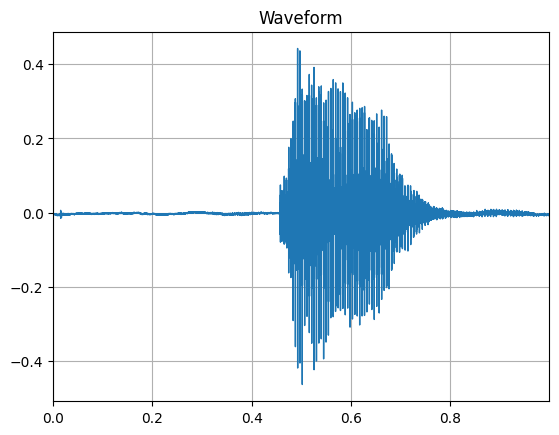

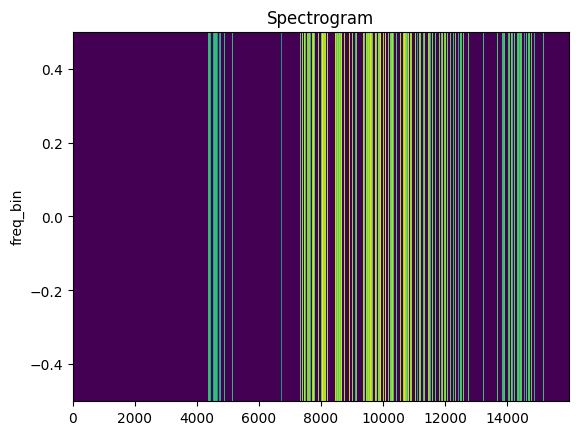

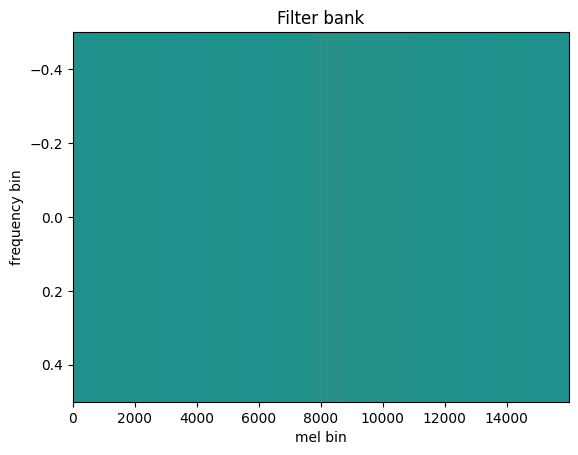

In [5]:
print(f"Train set length: {len(train_set)}")
print(f"Test set length: {len(test_set)}")

idx = 1 #seleziona un campione dal dataset es. indice=1

waveform, sample_rate, label, speaker_id, utterance_number = train_set[idx]

print(f"Sample metadata. Label: {label}, Speaker: {speaker_id}, Utterance no. {utterance_number}")
print("Shape of waveform: {}".format(waveform.size()))
print("  Number of channels: {}".format(waveform.size()[0]))
print("  Number of samples: {}".format(waveform.size()[1]))
print("Sample rate of waveform: {} Hz".format(sample_rate))

# TASK: WAVEFORM PLOT

#traccia la forma d'onda e stampane la forma.
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

num_campioni=waveform.shape[1]
sec=num_campioni/sample_rate
print("Seconds: {} s".format(sec))

plot_waveform(waveform, sample_rate)
plot_spectrogram(waveform, title="Spectrogram")
plt.show()
plot_fbank(waveform, title="Filter bank")
plt.show()

Run the following cell and listen to the sample.



In [6]:
print(f"Listen to sample no. {idx} with utterance_number: {utterance_number}")
print(f" Speaker {speaker_id} saying '{label}'")
print()
#Ascolta lo stesso campione con "ipd.Audio(<forma d'onda>, )"
ipd.display(ipd.Audio(waveform.numpy(), rate=sample_rate))

Listen to sample no. 1 with utterance_number: 0
 Speaker 004ae714 saying 'down'



Let’s find the list of labels available in the dataset. (it takes at least 1.5 minutes)




In [7]:
print(f"Counting number of labels in the dataset (be patient) ...")

# or just list the command subset
labels = list(commands)
counts = pd.Series(datapoint[2] for datapoint in train_set).value_counts();
labels = [ lbl for lbl, cnt in counts.items()]
print(labels)
counts

Counting number of labels in the dataset (be patient) ...
['yes', 'down', 'no', 'stop', 'go', 'left', 'right', 'up']


,count
yes,3228
down,3134
no,3130
stop,3111
go,3106
left,3037
right,3019
up,2948


# **Ricampionamento**
Ricampionare a 8khz e vedere le differenza rispetto ai 16kHz di default poi vedere anche 4khz ma sarà basso

In [8]:
import torchaudio
import torchaudio.transforms as T

# 1. Definisci le variabili di input (Supponiamo che l'audio sia a 16 kHz)
original_sample_rate = sample_rate # Esempio di frequenza originale
# waveform = ... # tensore PyTorch della forma d'onda

# 2. Definisci la frequenza target
resample_freq = 8000  # Vogliamo ricampionare a 4 kHz

# 3. Inizializza la trasformazione Resample
# Il primo argomento è la frequenza originale, il secondo è la frequenza target.
resampler = T.Resample(
    orig_freq=original_sample_rate,
    new_freq=resample_freq
)

# 4. Applica la trasformazione
waveform_8k = resampler(waveform)

# 5. La nuova frequenza di campionamento è 8000 Hz
new_sample_rate = resample_freq

sample_rate=new_sample_rate
waveform=waveform_8k;

Wavefrom, Spectogram e Filter Bank con Ricampionamento

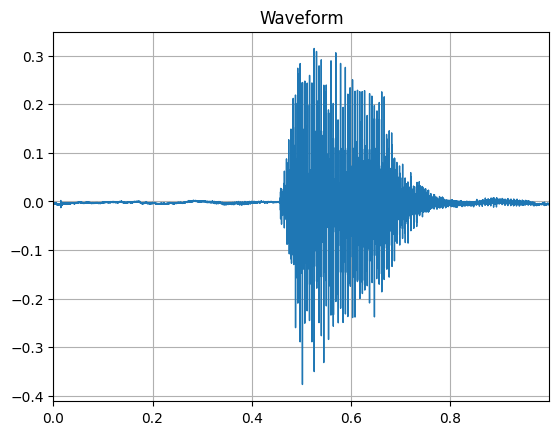

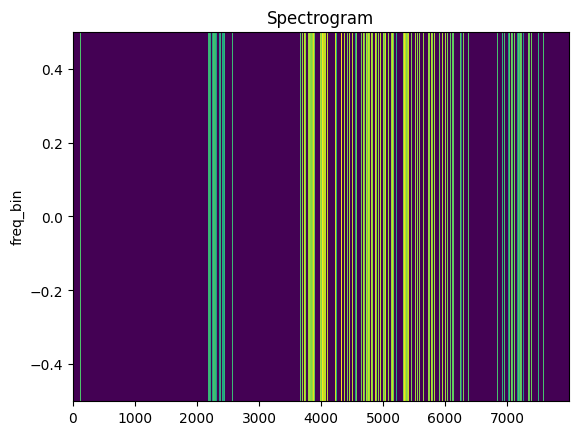

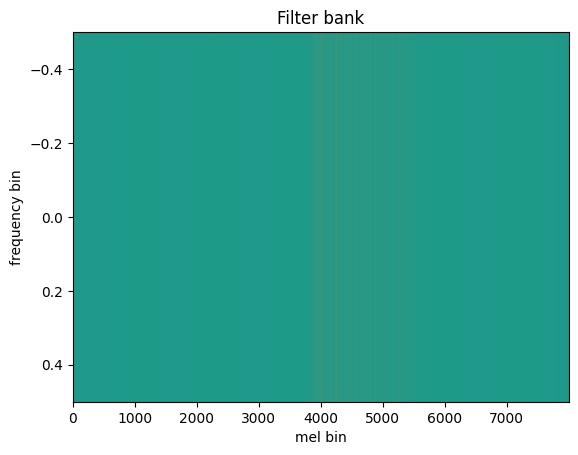

In [9]:
sec=waveform/sample_rate
plot_waveform(waveform, sample_rate)
plot_spectrogram(waveform, title="Spectrogram")
plt.show()
plot_fbank(waveform, title="Filter bank")
plt.show()

## Mel Spectrogram

**Task: Mel Spectrogram.** Spettrogramma Mel. Utilizzare le trasformazioni di Torchaudio per trasformare i dati campione in un'immagine, ovvero lo spettrogramma Mel. Per prima cosa, utilizzare i parametri predefiniti, quindi seguire il tutorial di Pytorch sull'estrazione di caratteristiche audio e sperimentare con diversi parametri: win_length: la lunghezza del frame, hop_length: la lunghezza del "passo", n_fft: il numero di intervalli di frequenza, n_mels: il numero di bande Mel. Un possibile risultato è mostrato nella figura seguente.


* Quanti campioni (potenza di due)
corrispondono a una finestra di circa 10 ms? Perché si usa spesso 10 ms?

*  Qual è il rapporto comune tra la lunghezza della finestra e la dimensione dell'intervallo di salto?

* Quanti intervalli FFT o bande Mel sono comunemente utilizzati nelle reti di deep learning? Vedere alcuni esempi nelle slide e notare se i numeri dipendono dalla frequenza di campionamento. Viene utilizzato lo stesso valore per entrambi o no?

* Ricordarsi di calcolare i valori dello spettrogramma in dB (ovvero, scala logaritmica).


![picture](https://gist.githubusercontent.com/servetti-polito/b976ba016411f0c3905bf89e18a28899/raw/fc17ffa3e44ef402e5995619cf42f6908f88d84e/mel-spectrogram.png)

In [10]:
!pip install librosa

In [11]:
import torch
import torchaudio
import torchaudio.transforms as T
print(torch.__version__)
print(torchaudio.__version__)

import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
from matplotlib.patches import Rectangle
# The 'download_asset' function was removed or moved in recent versions of torchaudio.
# If you need to download a sample, consider using 'torch.hub.load' or manual download.
# For now, we'll set SAMPLE_SPEECH to a placeholder.

torch.random.manual_seed(0)

# Define SAMPLE_SPEECH with a path to an audio file.
# You can manually download the asset from the tutorial:
# https://pytorch.org/tutorials/_static/img/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav
# For example, save it as 'tutorial_sample.wav' in '/content/' and set:
SAMPLE_SPEECH = "/content/tutorial_sample.wav"


# Download the sample audio file if it doesn't exist
import os
if not os.path.exists(SAMPLE_SPEECH):
    # Using a different sample audio URL since the previous one was 404
    !wget -O {SAMPLE_SPEECH} https://pytorch.org/tutorials/_static/img/steam-train-whistle-40-ms.wav
# If you don't have a sample audio file at this path, the next cell will fail to load it.



2.9.0+cu126
2.9.0+cu126
--2025-12-11 13:44:03--  https://pytorch.org/tutorials/_static/img/steam-train-whistle-40-ms.wav
Resolving pytorch.org (pytorch.org)... 23.185.0.2, 2620:12a:8000::2, 2620:12a:8001::2
Connecting to pytorch.org (pytorch.org)|23.185.0.2|:443... connected.
Unable to establish SSL connection.


Shape of Mel spectrogram (dB): torch.Size([1, 128, 51])
Sample rate of waveform: 8000 Hz


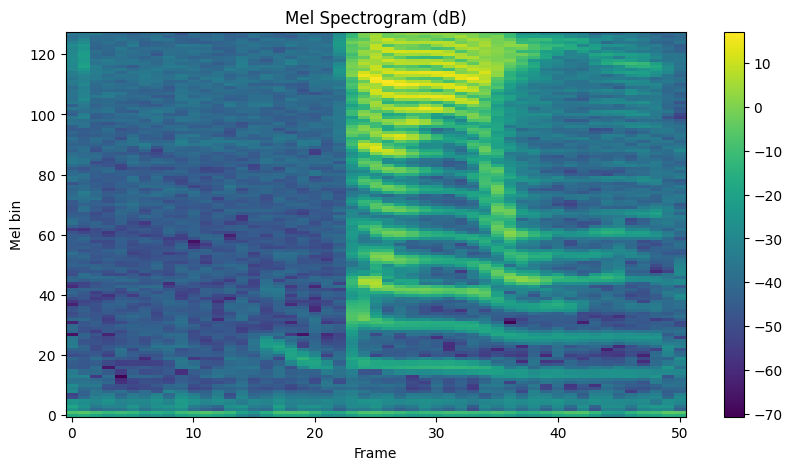

In [12]:
# TASK. MEL SPECTROGRAM
from IPython.display import Audio
from matplotlib.patches import Rectangle
# The download_asset function has been removed in recent torchaudio versions.
# We will use the SAMPLE_SPEECH defined in the previous cell which points to a local file.

#torch.random.manual_seed(0)

# Load audio using the SAMPLE_SPEECH path from the previous cell
# SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)

# Fix: Use the waveform and sample_rate already loaded from the dataset (from cell JcGUx8sUD3xK)
# These variables are globally available in the kernel after executing JcGUx8sUD3xK
SPEECH_WAVEFORM = waveform
SAMPLE_RATE = sample_rate
n_fft = 400 # Example: 25ms window for 16kHz corresponds to 400 samples (0.025 * 16000)
win_length = None #lunghezza frame
hop_length = 160 # Example: 10ms hop length (tempo finestra ms*freqeunza campionamento=0.010 * 16000)
n_mels=128 # Example number of mel bands

# Define the Mel Spectrogram transform and AmplitudeToDB transform as per the task
mel_spectrogram_transform = T.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    n_mels=n_mels,
)
amplitude_to_db_transform = T.AmplitudeToDB()

# Perform transform: first MelSpectrogram, then convert to dB
mel_spec = mel_spectrogram_transform(SPEECH_WAVEFORM)
dbmelspec = amplitude_to_db_transform(mel_spec)

print("Shape of Mel spectrogram (dB): {}".format(dbmelspec.shape))

print("Sample rate of waveform: {} Hz".format(sample_rate))

plt.figure(figsize=(10,5))
plt.xlabel('Frame');
plt.ylabel('Mel bin');
plt.imshow(dbmelspec[0], origin="lower", aspect="auto", interpolation="nearest")
plt.colorbar()
plt.title("Mel Spectrogram (dB)")
plt.show()


Dal tutorial su Pytorch
https://docs.pytorch.org/audio/stable/tutorials/audio_feature_extractions_tutorial.html

In [13]:
# Define transform
spectrogram = T.Spectrogram(n_fft=512)

# Perform transform
spec = spectrogram(SPEECH_WAVEFORM)

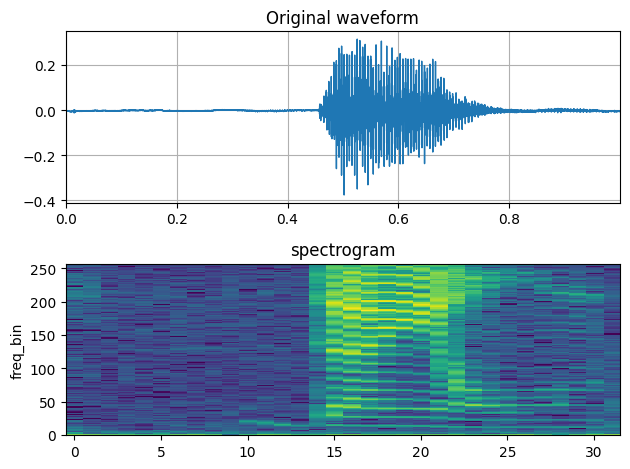

In [14]:
fig, axs = plt.subplots(2, 1)
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
fig.tight_layout()

In [15]:
Audio(SPEECH_WAVEFORM.numpy(), rate=SAMPLE_RATE)

**L'effetto del n_fftparametro**

Il valore di n_fftdetermina la risoluzione dell'asse delle frequenze. Tuttavia, con un n_fftvalore più alto, l'energia verrà distribuita tra più intervalli, quindi quando la si visualizza, potrebbe apparire più sfocata, anche se la risoluzione è più alta.

In [16]:
n_ffts = [32, 128, 512, 2048]
hop_length = 20
specs = []
for n_fft in n_ffts:
    spectrogram = T.Spectrogram(n_fft=n_fft, hop_length=hop_length)
    spec = spectrogram(SPEECH_WAVEFORM)
    specs.append(spec)

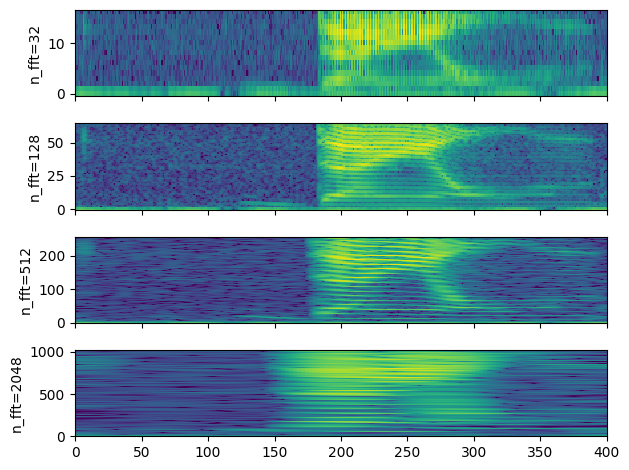

In [17]:
fig, axs = plt.subplots(len(specs), 1, sharex=True)
for i, (spec, n_fft) in enumerate(zip(specs, n_ffts)):
    plot_spectrogram(spec[0], ylabel=f"n_fft={n_fft}", ax=axs[i])
    axs[i].set_xlabel(None)
fig.tight_layout()

Come abbiamo visto sopra, la modifica del valore di n_fft non modifica la copertura della gamma di frequenza per lo stesso segnale di ingresso.

Riduciamo il campionamento dell'audio e applichiamo uno spettrogramma con lo stesso n_fft valore.

In [18]:
# Downsample to half of the original sample rate
speech2 = torchaudio.functional.resample(SPEECH_WAVEFORM, SAMPLE_RATE, SAMPLE_RATE // 2)
# Upsample to the original sample rate
speech3 = torchaudio.functional.resample(speech2, SAMPLE_RATE // 2, SAMPLE_RATE)

In [19]:
# Apply the same spectrogram
spectrogram = T.Spectrogram(n_fft=512)

spec0 = spectrogram(SPEECH_WAVEFORM)
spec2 = spectrogram(speech2)
spec3 = spectrogram(speech3)

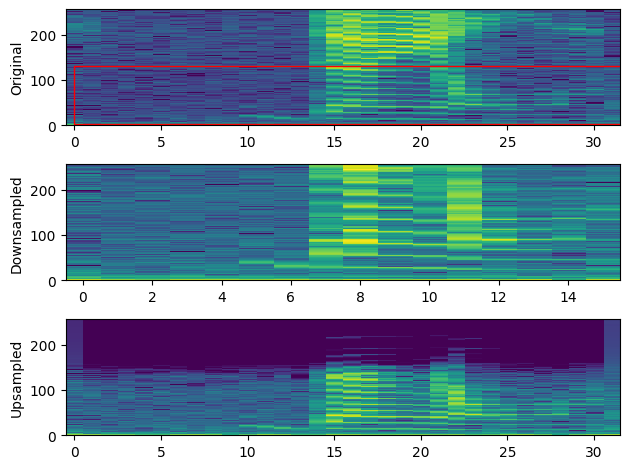

In [20]:
# Visualize it
fig, axs = plt.subplots(3, 1)
plot_spectrogram(spec0[0], ylabel="Original", ax=axs[0])
axs[0].add_patch(Rectangle((0, 3), 212, 128, edgecolor="r", facecolor="none"))
plot_spectrogram(spec2[0], ylabel="Downsampled", ax=axs[1])
plot_spectrogram(spec3[0], ylabel="Upsampled", ax=axs[2])
fig.tight_layout()

Nella visualizzazione sopra, il secondo grafico ("Downsampled") potrebbe dare l'impressione che lo spettrogramma sia allungato. Questo perché il significato dei bin di frequenza è diverso da quello originale. Sebbene abbiano lo stesso numero di bin, nel secondo grafico la frequenza è coperta solo fino a metà della frequenza di campionamento originale. Questo diventa più chiaro se ricampionamo nuovamente il segnale sottocampionato in modo che abbia la stessa frequenza di campionamento dell'originale.

**Mel spectogram**

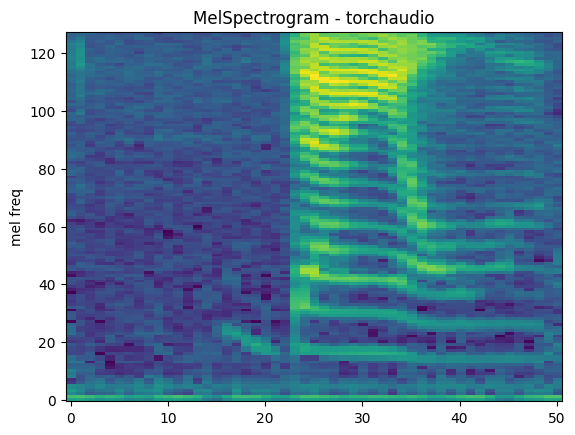

In [21]:
plot_spectrogram(mel_spec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

## Formatting the data



Functions `label_to_index` and `index_to_label` are used to map (and encode) each word with its index in the list of labels.



In [22]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(0) --> yes


Per trasformare un elenco di punti dati composto da registrazioni audio e frasi in due tensori in batch per il modello, implementiamo una funzione di collate, utilizzata da PyTorch DataLoader, che ci consente di iterare su un set di dati in batch.
Please see the documentation for more information about working with a [collate function](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn).



In [23]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Generic functions for training and testing the network model

Now let’s define a *generic* training function that will feed our training data into the model and perform the backward pass and optimization steps. The network will then be tested after each epoch to see how the accuracy varies during the training.

The *generic* function receives as parameters:
* The **trasform** function to apply to the data (or `None`).
* The **criterion** function for computing the loss.
* The **optimizer** to be used during the process.

In [24]:
def train(model, transform, criterion, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        if transform != None :
          data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        # loss = F.nll_loss(output.squeeze(), target)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print()
            print(f"       Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]")
            print(f"       Loss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)

        # record loss
        losses.append(loss.item())



Now that we have a *generic* training function, we need to make a *generic* one for testing the networks accuracy. We will set the model to `eval()` mode and then run inference on the test dataset. Calling `eval()` sets the training variable in all modules in the network to false. Certain layers like batch normalization and dropout layers behave differently during training so this step is crucial for getting correct results.

In [25]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, transform, criterion, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        if transform != None :
          data = transform(data)

        output = model(data)
        loss = criterion(output, target)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)


    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Define a *generic* predictor end evaluate function to be used in the evaluation phase.

In [26]:
# Returns the predict function binded to the model and transform
def predictor(model, transform):

    def p(tensor):
      # Use the model to predict the label of the waveform
      tensor = tensor.to(device)
      tensor = transform(tensor)
      tensor = model(tensor.unsqueeze(0))
      tensor = get_likely_index(tensor)
      tensor = index_to_label(tensor.squeeze())
      return tensor

    return p


def evaluate(losses, predict, eval_set):

  # Let's plot the training loss versus the number of iteration.
  plt.plot(losses);
  plt.title("training loss");

  cnt = 0

  for i, (waveform, sample_rate, utterance, *_) in enumerate(eval_set):
      try:
          output = predict(waveform)
      except:
          None
          # print("An exception occurred ", utterance, output)
      if output != utterance:
          # ipd.Audio(waveform.numpy(), rate=sample_rate)
          # print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
          print('-', end="")
      else:
          print('*', end="")
          cnt = cnt + 1
      if(not((i+1) % 100)):
        print()

  return cnt/len(eval_set)

# Part I

## Mel spectrogram model (with 2D transformation)



**Task: Mel Spectrogram Transform.** Starting from the data visualization section where the Mel Spectrogram of a sample has been computed, build _transform pipeline_ to convert the audio samples to the Mel spectrogram representation.

* H: check the shape of the 2D array before using it as input to the model, i.e. the number of bins (values) both in the time and frequency domain.


In [27]:
import torch
import torch.nn as nn
import torchaudio.transforms as T
import matplotlib.pyplot as plt

# --- Parametri ---
n_fft = 400        # 25ms window @ 16kHz
win_length = None  # Default a n_fft
hop_length = 160   # 10ms hop @ 16kHz
n_mels = 128       # Altezza immagine (Frequency bins)
stretch_factor=0.8

# --- Creazione della Pipeline (Il "Pacchetto") ---
# Define custom feature extraction pipeline.
#
# 1. Resample audio
# 2. Convert to power spectrogram
# 3. Apply augmentations
# 4. Convert to mel-scale

#1
resampleFn = torchaudio.transforms.Resample(
    orig_freq = sample_rate,
    new_freq = resample_freq
)
#2
sepctogramFn=torchaudio.transforms.Spectrogram(
    n_fft=n_fft, win_length=win_length,hop_length=hop_length,power=2)
#3 Agumentation lo facciamo dopo

frequencyMask=T.FrequencyMasking(freq_mask_param=80);
timeMask=T.TimeMasking(time_mask_param=80)


#4
melScaleFn=torchaudio.transforms.MelScale(n_mels=n_mels,sample_rate=resample_freq, n_stft=n_fft//2+1)

resampled = resampleFn(waveform)
specgram = sepctogramFn(resampled)
melspec = melScaleFn(specgram)

dbmelspec = librosa.power_to_db(melspec)

# print("Shape of spectrogram: {}".format(dbmelspec))


**Prima di definire la rete, devi sapere quanto è grande l'immagine in input.**

La forma (shape) del tensore finale dbmelspec sarà generalmente nel formato:$$\text{Shape} = (\text{Canali}, \text{Bande Mel}, \text{Frame Temporali})$$
1. Dominio della Frequenza (Asse Y)
- Numero di Bins in Frequenza: Corrisponde al parametro n_mels.
- Valore: 128.
- Significato: Questo è il numero di caratteristiche che il modello vedrà nel dominio della frequenza logaritmica. Ogni riga del tuo spettrogramma rappresenta una banda Mel
2. Dominio del Tempo (Asse X)
- Numero di Bins nel Tempo (Frame): Dipende dalla lunghezza totale della forma d'onda ($\text{Lunghezza}$) e dai parametri n_fft e hop_length.
- Formula: Il numero di frame temporali ($N_{\text{frame}}$) è calcolato approssimativamente come:$$N_{\text{frame}} \approx \lfloor \frac{\text{Lunghezza} - \text{n\_fft}}{\text{hop\_length}} \rfloor + 1$$
- Significato: Questo è il numero di "fotogrammi" temporali dello spettrogramma. Ogni colonna del tuo spettrogramma rappresenta una finestra di tempo che si sposta di $10\ \text{ms}$ (hop_length).

Per i modelli di Deep Learning, il tensore bidimensionale (128 Bande Mel $\times$ X Frame) è l'input principale.

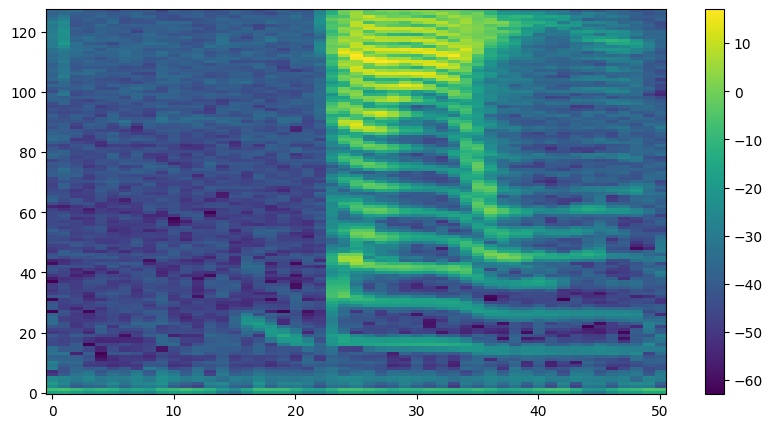

(1, 128, 51)

In [28]:
# --- Visualizzazione ---

plt.figure(figsize=(10,5))
plt.imshow(dbmelspec[0], origin="lower", aspect="auto", interpolation="nearest")
plt.colorbar()
plt.show()
#stampa la shape per ottenere qualcosa come (1,128,X)=(canale es scala di grigi, y frequency, x time frames)
melspec.numpy().shape
#questa info serve alla rete cnn per sapere le dimensioni per definire il primo layer lineare fully connected dopo le convoluzioni

**Task. 2D Newtork Model.**  Define a convolutional neural network (CNN) starting from the architecture implemented in Lab n.03 for the fashion MINST dataset and adapting its structure to the data at hand.




In [29]:
## TASK. BUILD THE NETWORK MODEL

# class CNN(nn.Module): x

# model_CNN = x

## TASK. BUILD THE TRANSFORM PIPELINE
# See pipeline at https://pytorch.org/audio/stable/transforms.html

# transform_CNN =

# criterion_CNN =

In [30]:
# Build the neural network, expand on top of nn.Module
class CnnClassifier(nn.Module):
  def __init__(self, num_class):
    super().__init__()

    # define layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)

    self.flatten = nn.Flatten()

    self.fc1 = nn.Linear(in_features=3200, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=num_class)

  # define forward function
  def forward(self, t):
    # conv 1
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # conv 2
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # fc1
    t = self.flatten(t)
    t = self.fc1(t)
    t = F.relu(t)

    # fc2
    t = self.fc2(t)
    t = F.relu(t)

    # output
    t = self.out(t)
  #  t = F.log_softmax(t, dim=1)

    # don't need softmax here since we'll use cross-entropy as activation.

    return t


In [31]:
## TASK. BUILD THE TRANSFORM PIPELINE
# See pipeline at https://pytorch.org/audio/stable/transforms.html

# transform_CNN =

# criterion_CNN =

In [43]:
model_cnn = CnnClassifier(35)

transform_cnn = nn.Sequential(
 resampleFn,
 sepctogramFn,
 melScaleFn,
 torchvision.transforms.Resize((28,28))
)

transfrom_agum=nn.Sequential(resampleFn,
 sepctogramFn,
 melScaleFn,
frequencyMask,
timeMask,torchvision.transforms.Resize((28,28)))


### Training and testing

**Task.** Train and test the network model. _Assign to the model, transform, and criterion variables the classes or functions to be used for the specific model at hand._

* Q: Do the result change using the default MelSpectrogram transform or the customized one with different window, fft, and mel parameters?

* Repeat the processing, training and test the results. Consider changing the input representation, the network architecture, or the network hyper-parameters

* Plot the training loss versus the number of iterations.

* Look at the prediction performance and annotate the results for the comparison with the 1D model.

In [44]:
# UNCOMMENT and CUSTOMIZE with the proper model, transform and criterion (either for 1D or 2D networks)
model = model_cnn
transform = transform_cnn
transform_train=transfrom_agum
criterion = nn.CrossEntropyLoss()

log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
model = model.to(device)
transform = transform.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                              steps_per_epoch=int(len(train_loader)),
                                              epochs=n_epoch,
                                              anneal_strategy='linear')



print("Number of parameters: %s" % sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)

with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, transform_train, criterion, optimizer, epoch, log_interval)
        test(model, transform, criterion, epoch)
#        scheduler.step()

Number of parameters: 468011
CnnClassifier(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3200, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=35, bias=True)
)


  0%|          | 0.00909090909090909/2 [00:01<04:43, 142.42s/it]


       Train Epoch: 1 [0/24713 (0%)]
       Loss: 3.640405


 10%|▉         | 0.19090909090909094/2 [00:18<02:49, 93.66s/it]


       Train Epoch: 1 [5120/24713 (21%)]
       Loss: 3.466115


 19%|█▊        | 0.3727272727272728/2 [00:35<02:27, 90.77s/it]


       Train Epoch: 1 [10240/24713 (41%)]
       Loss: 3.494775


 28%|██▊       | 0.5545454545454543/2 [00:53<02:17, 95.27s/it]


       Train Epoch: 1 [15360/24713 (62%)]
       Loss: 3.493582


 37%|███▋      | 0.7363636363636351/2 [01:11<02:21, 111.61s/it]


       Train Epoch: 1 [20480/24713 (82%)]
       Loss: 3.432013


 50%|████▉     | 0.9999999999999972/2 [01:36<01:23, 83.22s/it]


Test Epoch: 1	Accuracy: 602/3276 (18%)



 50%|█████     | 1.0090909090909064/2 [01:37<01:27, 88.02s/it]


       Train Epoch: 2 [0/24713 (0%)]
       Loss: 3.406167


 60%|█████▉    | 1.1909090909090871/2 [01:54<01:15, 93.81s/it]


       Train Epoch: 2 [5120/24713 (21%)]
       Loss: 2.763499


 69%|██████▊   | 1.372727272727268/2 [02:12<00:56, 90.55s/it] 


       Train Epoch: 2 [10240/24713 (41%)]
       Loss: 3.120183


 78%|███████▊  | 1.5545454545454487/2 [02:30<00:43, 97.97s/it] 


       Train Epoch: 2 [15360/24713 (62%)]
       Loss: 2.793389


 87%|████████▋ | 1.7363636363636294/2 [02:48<00:24, 93.70s/it]


       Train Epoch: 2 [20480/24713 (82%)]
       Loss: 2.624398


100%|█████████▉| 1.9999999999999916/2 [03:14<00:00, 97.03s/it] 


Test Epoch: 2	Accuracy: 860/3276 (26%)




-------------------------------------------*-------*--------------*---------------------------------
---------------------------------------------------**--------------------*--------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------*-----------------------**-*----*---*--------***
---*--**-------*---***----*--*---*--*--**--*-**-*---***--**---***--*-*-******-------****----*-***---
-*--**-*-*-----**-*-*****-*-*--*-**-*-*-*---**--*-****-*--*---**-----*-*----****-***------------**--
--*-*--**-*--------**-**-----*-*---*-**-*-***-*****--*-**-*--******---*-**-*-**--*-*--*--****----*-*
----*****-*-**-**---**--*--*-*-***--------*-----*------------*--*-----*----**-*---*-*---*------*---*
-*----*---*----------------------**--------*-**-*-*---*-----*------------***---*-*----*-*------*----
--------**----**-------*------*--*-----------*---*-**-------------*-------------**-----*--

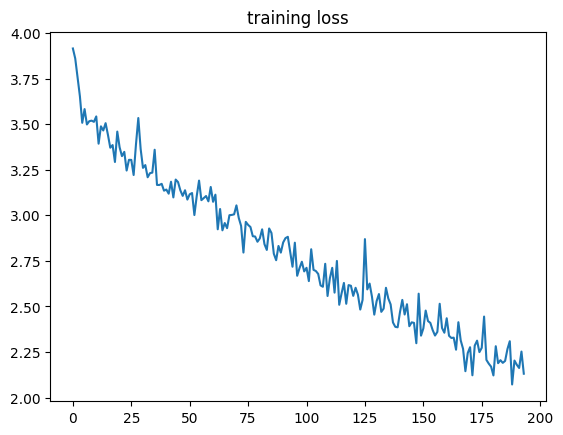

In [34]:
# Evaluate on the validation set
predict = predictor(model, transform)
print()
perc = evaluate(losses, predict, valid_set)
print()
print("Validation set prediction accuracy: ", perc)


# Part II

## End-to-end model (i.e., no data processing)

As a first example we will use **the raw audio data** and a 1D convolutional neural network. Usually more advanced transforms are applied to the audio data, however CNNs can also be used to process the raw data.

**Task.** Build a network model with architecture defined as M5 in the paper [Very deep convolutional neural networks for raw waveforms](https://arxiv.org/pdf/1610.00087.pdf).

An important aspect of models processing raw audio data is the receptive field of their first layer’s filters. This model’s first filter is length 80 so when processing audio sampled at 8kHz the receptive field is around 10ms (and at 4kHz, around 20 ms). This size is similar to speech processing applications that often use receptive fields ranging from 20ms to 40ms.

![picture](https://gist.githubusercontent.com/servetti-polito/b976ba016411f0c3905bf89e18a28899/raw/d00e2d2e3c00b96c68be26d3ee3c2deaec106868/m5-model.small.jpg)

Here is a model example.
```
M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=8, bias=True)
)
```

**Task.** For the waveform, we define a **transform function** to downsample the audio (see `torchaudio.transforms.Resample`) for faster processing without losing too much of the classification power.
* Q: Which _reduced_ sample rate can be used to preserve speech information?

We don’t need to apply other transformations here. It is common for some datasets though to have to reduce the number of channels (say from stereo to mono) by either taking the mean along the channel dimension, or simply keeping only one of the channels. Since SpeechCommands uses a single channel for audio, this is not needed here.

In [35]:
## TASK. BUILD THE NETWORK MODEL

# class M5(nn.Module):

# model_M5 =

## TASK. BUILD THE TRANSFORM PIPELINE
# See pipeline at https://pytorch.org/audio/stable/transforms.html

# transform_M5 =

criterion_M5 = lambda o,t: nn.NLLLoss()(o.squeeze(),t)


In [36]:
# Build the neural network, expand on top of nn.Module
class M5(nn.Module):
  def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
    super().__init__()

    # define layers
    self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
    self.bn1 = nn.BatchNorm1d(32)
    self.pool1 = nn.MaxPool1d(4)
    self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3)
    self.bn2 = nn.BatchNorm1d(32)
    self.pool2 = nn.MaxPool1d(4)
    self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
    self.bn3 = nn.BatchNorm1d(64)
    self.pool3 = nn.MaxPool1d(4)
    self.conv4 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3)
    self.bn4 = nn.BatchNorm1d(64)
    self.pool4 = nn.MaxPool1d(4)

    self.fc1 = nn.Linear(in_features=64, out_features=8)
    #self.out = nn.Linear(in_features=60, out_features=num_class)

  # define forward function
  def forward(self, t):
    # conv 1
    t = self.conv1(t)
    t = F.relu(self.bn1(t))
    t = self.pool1(t)

    # conv 2
    t = self.conv2(t)
    t = F.relu(self.bn2(t))
    t = self.pool2(t)

    # conv 3
    t = self.conv3(t)
    t = F.relu(self.bn3(t))
    t = self.pool3(t)

    # conv 4
    t = self.conv4(t)
    t = F.relu(self.bn4(t))
    t = self.pool4(t)

    # fc1
    t = F.avg_pool1d(t, t.shape[-1])
    t = t.permute(0, 2, 1)
    t = self.fc1(t)

    # output
   # t = self.out(t)
    t = F.log_softmax(t, dim=2)

    return t


In [37]:
model_M5 = M5(n_input=1, n_output=len(labels))
# DATA TRANSFORM (resampling to 8 kHz)
resample_freq=8000
transform_M5 = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=resample_freq)

### Training and testing

Finally, we can train and test the network. The network will be tested after each epoch to see how the accuracy varies during the training.

The network should be more than 65% accurate on the test set after 2 epochs, and 85% after 21 epochs.

Note. We will use the same optimization technique used in the paper, an Adam optimizer with weight decay set to 0.0001. If the number of epoch is greater than 20, an optimizer can be added in order to decrease the weight decay.

**Task.** Train and test the network model. Assign to the `model`, `transform`, and `criterion` variables the classes or functions to be used for the specific model at hand.   




In [38]:
# CUSTOMIZE with the proper model, transform and criterion (either for 1D or 2D networks)
model = model_M5
transform = transform_M5
criterion = criterion_M5

log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
model = model.to(device)
transform = transform.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
## At first, we will train with a learning rate of 0.01, but we will use a scheduler to decrease it to 0.001 during training after 20 epochs.
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10


print("Number of parameters: %s" % sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)

with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, transform, criterion, optimizer, epoch, log_interval)
        test(model, transform, criterion, epoch)
#        scheduler.step()


Number of parameters: 25160
M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_fea

  0%|          | 0.00909090909090909/2 [00:00<03:28, 104.63s/it]


       Train Epoch: 1 [0/24713 (0%)]
       Loss: 2.189541


 10%|▉         | 0.19090909090909094/2 [00:17<02:45, 91.56s/it]


       Train Epoch: 1 [5120/24713 (21%)]
       Loss: 1.429316


 19%|█▊        | 0.3727272727272728/2 [00:35<02:46, 102.59s/it]


       Train Epoch: 1 [10240/24713 (41%)]
       Loss: 0.846987


 28%|██▊       | 0.5545454545454543/2 [00:52<02:14, 93.28s/it]


       Train Epoch: 1 [15360/24713 (62%)]
       Loss: 0.780285


 37%|███▋      | 0.7363636363636351/2 [01:09<01:53, 90.09s/it]


       Train Epoch: 1 [20480/24713 (82%)]
       Loss: 0.716682


 50%|████▉     | 0.9999999999999972/2 [01:34<01:23, 83.02s/it]


Test Epoch: 1	Accuracy: 2404/3276 (73%)



 50%|█████     | 1.0090909090909064/2 [01:35<01:30, 91.57s/it]


       Train Epoch: 2 [0/24713 (0%)]
       Loss: 0.586664


 60%|█████▉    | 1.1909090909090871/2 [01:53<01:16, 94.49s/it]


       Train Epoch: 2 [5120/24713 (21%)]
       Loss: 0.595502


 69%|██████▊   | 1.372727272727268/2 [02:10<01:04, 102.58s/it]


       Train Epoch: 2 [10240/24713 (41%)]
       Loss: 0.481401


 78%|███████▊  | 1.5545454545454487/2 [02:28<00:42, 95.98s/it]


       Train Epoch: 2 [15360/24713 (62%)]
       Loss: 0.531026


 87%|████████▋ | 1.7363636363636294/2 [02:52<00:35, 136.49s/it]


       Train Epoch: 2 [20480/24713 (82%)]
       Loss: 0.497938


100%|█████████▉| 1.9999999999999916/2 [03:22<00:00, 101.18s/it]


Test Epoch: 2	Accuracy: 2611/3276 (80%)



### Evaluate the model.

* Plot the training loss versus the number of iterations

* Look at the samples in the validation set and see how the model performs on it



--**-******-*-*****-***-*-**--*-****-*--************-*******-*-****-*-**-*--**-*-*-***-*-*****-*-*-*
-***-****-**---*****-************-****----***************-**-********************--*******-*-***-***
**-*****---*-*---****-**-*-**-*-*--**---*-*--******--***-*-*-**-*-****-***-**--****-********-*-*****
****-****************---****************-***-******-**--***-***------*--*--*---*---**--**--**-------
-*-**--**-**-*-******--**--**************-*-***********--****-***--*-*-******--****-***--*--******-*
******-************-*********-*****---********-************---******-****************-----*-***-****
*--*-**-****-*-*-**-*--**-*-**-*---*-********--*-******---*********-***-***-**--****---**-**-***--*-
-********-*********--*--*-****-***--***-***-*-*-**-*-*******--*-**-****-****-**-**-**-******-***-*-*
***-********---*-*-*-*---***-****-***---**************-********-*-***-**-*********----**-****-**--**
--*-**-****-*-*****-***--*******-**-*****--****-*-*-----****---*-**-***-***---*-***-*-*-*-

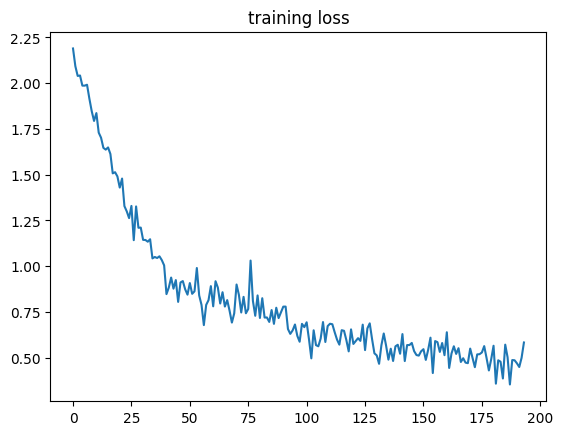

In [39]:
# Evaluate on the validation set
predict = predictor(model, transform)

print()
perc = evaluate(losses, predict, valid_set)
print()
print("Validation set prediction accuracy: ", perc)
